# Geometrics Data IO
This notebook demonstrates how to read in and manipulate geometrics data files. These files are ascii formatted text files, with an extension of `.stn`
> **Note**:
> These files have also been compressed in this repository to save some space, so the first step is to decompress them.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import io

from scipy.constants import hour, minute

# Base Station
First lets read in the base station data!

This file is pretty simple, each column is fixed width. As an example, here are some items from the file:

```base.stn```

> ```
 324 324 134226    3 503235
 324 324 134302    4 503246
*324 324 134417    5 503258
*324 324 134427    6 503252
*324 324 134437    7 503260
*324 324 134447    8 503237
> ```

The file is organized as follows:
 * The first column is a flag describing how it was collected (a `*` means automatically).
 * The next three digits indicate the starting Julian date.
 * The next three more digits for the current Julian date.
 * The next 6 digits in HHMMSS format (24 hour time hours, minutes and seconds).
 * The next digit is the reading number (which is automatically incremented for each reading).
 * Between the station number and the reading, there is either a whitespace or a `?`. If there is a
`?` it means the instrument was not callibrated before the reading.
 * Finally the last 6 digits of the line are the actual magnetic field reading, it is in units of 10 * (nT).

In [2]:
data_folder = Path('data/2024/')
# panda's read f(ixed)w(idth)f(ormat) function!
base_df = pd.read_fwf(data_folder / 'base.stn', widths=[1, 3, 4, 7, 5, 1, 6], header=None, skipfooter=1)

# Lets give the columns some appropriate names
base_df = base_df.rename(
    columns={
        0:'store flag',
        1:'start date (days)',
        2:'reading date (days)',
        3:'reading time (HHMMSS)',
        4:'reading number',
        5:'calibration flag',
        6:'reading (10 nT)',
    }
)
base_df

,store flag,start date (days),reading date (days),reading time (HHMMSS),reading number,calibration flag,reading (10 nT)
0,*,502,324,133503,0,?,504110
1,NaN,324,324,134127,1,?,499539
2,NaN,324,324,134138,2,?,504742
3,NaN,324,324,134226,3,NaN,503235
4,NaN,324,324,134302,4,NaN,503246
...,...,...,...,...,...,...,...
659,*,324,324,153317,659,NaN,503399
660,*,324,324,153327,660,NaN,503397
661,*,324,324,153337,661,NaN,503363
662,*,324,324,153347,662,NaN,503384


Let's do some date time conversions! Since we know all of our data were collected on the same day, let's ignore the "day" column for these data sets.

In [3]:
# let's convert the reading date and time to a single number (days probably)
reading_time = base_df['reading time (HHMMSS)']
# floor divide by 10000 to isolate the HH times!
reading_hour = reading_time // 10_000 * hour
# takes the remainder after division by 10_000, then floor divide by 100 to get the minutes
reading_minute = (reading_time % 10_000) // 100 * minute
# remainder after division by 100, for the seconds!
reading_second = (reading_time % 100)

base_reading_time = reading_hour + reading_minute + reading_second

# this is now in terms of decimal seconds.
base_reading_time

0      48903.0
1      49287.0
2      49298.0
3      49346.0
4      49382.0
        ...   
659    55997.0
660    56007.0
661    56017.0
662    56027.0
663    56037.0
Name: reading time (HHMMSS), Length: 664, dtype: float64

In [4]:
# get the reading in units of nT!
base_reading = base_df['reading (10 nT)'] / 10  # for conversion from 10 * nT to nT

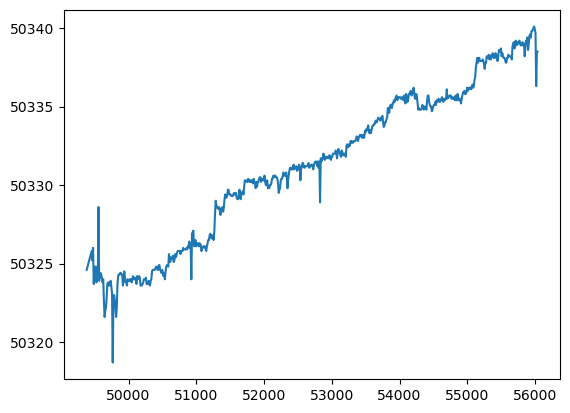

In [5]:
# cutout the first few take while we were setting up the base
plt.plot(base_reading_time[4:], base_reading[4:])

# Reading the rover's data
Next we want to read in the data from the rover, lines containing data look like:

> ```
> 0   50379.188  50378.764 15:31:21.40 11/19/24   0
> 0   50378.522  50378.901 15:31:21.30 11/19/24   0
> 0   50377.796  50380.756 15:31:21.20 11/19/24   0
> 0   50377.877  50382.289 15:31:21.10 11/19/24   0
> 0   50378.879  50382.579 15:31:21.00 11/19/24   0
> 0   50379.680  50382.365 15:31:20.90 11/19/24   0
> 0   50380.195  50382.016 15:31:20.80 11/19/24   0
> 0   50381.417  50381.783 15:31:20.70 11/19/24   0
> 0   50382.405  50379.210 15:31:20.60 11/19/24   0
> 0   50382.777  50375.087 15:31:20.50 11/19/24   0
> 0   50382.492  50371.202 15:31:20.40 11/19/24   0
> ```

Which is again a fixed width format, however there are other lines every once and a while in the file:

> ```
> 0   50393.838  50379.330 15:30:17.20 11/19/24   0
> 0   50395.478  50376.614 15:30:17.10 11/19/24   0
> 0   50396.718  50371.366 15:30:17.00 11/19/24   0
> 6          0.00         0.00 15:30:17.00 11/19/24         58           3          42   4         40
> 0   50397.715  50359.374 15:30:16.90 11/19/24   0
> 0   50398.068  50340.153 15:30:16.80 11/19/24   0
> ```

or 

> ```
> 0   50387.555  50394.655 15:31:19.40 11/19/24   0
> 0   50387.963  50393.767 15:31:19.30 11/19/24   0
> 0   50388.133  50393.485 15:31:19.20 11/19/24   0
> 3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4
> 0   50387.965  50393.899 15:31:19.10 11/19/24   0
> 0   50387.338  50394.976 15:31:19.00 11/19/24   0
> 0   50386.985  50398.139 15:31:18.90 11/19/24   0
> ```

The first number in the line indicates the type of reading it is, in this case the `0` at the front means it was a magnetics data reading, in which case it is:

```Reading Type   Reading 1(nT)  Reading 2(nT)    Reading time (HH:MM:SS) Reading Date (MM/DD/YY) Flag```

In [7]:
# Let's start by reading only the rows that contained a `0` at the start
# we're going to do a little python trick to create a "virtual" file that
# only returns lines from the data file that start with 0

with open(data_folder/'rover.stn', 'r') as file:
    mag_lines = [line for line in file if line.startswith('0')]
virt_mag_file = io.StringIO("".join(mag_lines))

# then pass this virtual file to pandas to parse

mag_frame = pd.read_csv(virt_mag_file, header=None, sep=r'\s+')
mag_frame = mag_frame.rename(
    columns={
        0:'record type',
        1:'top sensor (nT)',
        2:'bottom sensor (nT)',
        3:'reading time (HH:MM:SS.SS)',
        4:'reading date (MM/DD/YY)',
    }
)

In [8]:
mag_frame

,record type,top sensor (nT),bottom sensor (nT),reading time (HH:MM:SS.SS),reading date (MM/DD/YY),5
0,0,50376.024,50364.917,15:31:22.30,11/19/24,0
1,0,50375.075,50368.614,15:31:22.20,11/19/24,0
2,0,50375.326,50372.764,15:31:22.10,11/19/24,0
3,0,50376.398,50376.899,15:31:22.00,11/19/24,0
4,0,50376.972,50380.068,15:31:21.90,11/19/24,0
...,...,...,...,...,...,...
18444,0,49425.789,49430.292,14:30:48.50,11/19/24,0
18445,0,49424.869,49430.071,14:30:48.40,11/19/24,0
18446,0,49424.457,49427.968,14:30:48.30,11/19/24,0
18447,0,49423.873,49427.860,14:30:48.20,11/19/24,0


In [9]:
# Convert the times to seconds
mag_frame['reading time (s)'] = pd.to_timedelta(
    mag_frame['reading time (HH:MM:SS.SS)']
).apply(pd.Timedelta.total_seconds)

(52148.1, 55982.3)

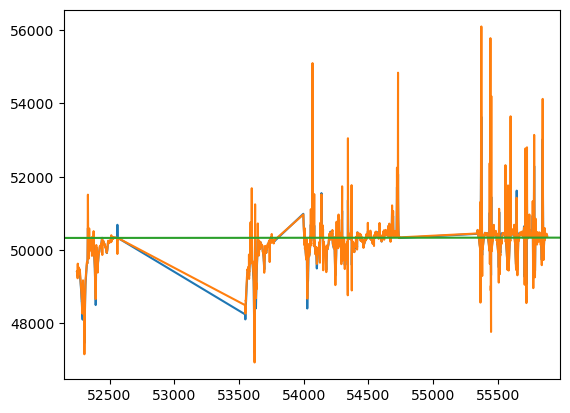

In [10]:
plt.plot(mag_frame['reading time (s)'], mag_frame['top sensor (nT)'])
plt.plot(mag_frame['reading time (s)'], mag_frame['bottom sensor (nT)'])
plt.plot(base_reading_time[4:], base_reading[4:])
plt.xlim([mag_frame['reading time (s)'].min()-100, mag_frame['reading time (s)'].max()+100])

# Marker lines
Lines in `rover.stn` that do not start with 0 are anything beside magnetics data that are recorded, let's look at them.

In [11]:
with open(data_folder/'rover.stn', 'r') as file:
    info_lines = [line[:-1] for line in file if not line.startswith('0')]
info_lines

['3          0.00         0.00 15:31:22.40 11/19/24         32           3          48   5',
 '3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4',
 '3          0.00         0.00 15:31:04.00 11/19/24        145           3          46   4',
 '3          0.00         0.00 15:30:49.50 11/19/24         52           3          45   4',
 '3          0.00         0.00 15:30:44.40 11/19/24        140           3          44   4',
 '3          0.00         0.00 15:30:30.40 11/19/24        134           3          43   4',
 '6          0.00         0.00 15:30:17.00 11/19/24         58           3          42   4         40',
 '3          0.00         0.00 15:30:11.20 11/19/24        137           3          41   4',
 '3          0.00         0.00 15:29:57.40 11/19/24        132           3          40   4',
 '3          0.00         0.00 15:29:44.30 11/19/24         46           3          39   4',
 '3          0.00         0.00 15:29:39.70 11/19/24        

Let's look closer at these lines

They look like:

> ```
> 3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4
> 3          0.00         0.00 15:31:04.00 11/19/24        145           3          46   4
> ...
> 6          0.00         0.00 14:36:15.00 11/19/24       3269           0           1   5          0
> ```

and so on, Here there's a few bits of information in this marker line:
From left to right:
* The reading type marker:
  * 3 is a position event (Marks or End lines)
  * 6 is a discontinuity event (usually the start of a line, but can also be marks).
* Two floats representing the station x and y location (if these were configured in the instrument)
* The time in HH:MM:SS.SS format
* The date in MM/DD/YY format
* The number of readings since the last marker
* The line number
* The marker number along that line
* (For reading type 6) The number of position (type 3) events since the last discontinuity
* Extra information for the magnetometer

You will need to look through your field notes, and decide which events correspond to which locations. At which point you will then assign a location to each of these locations.

Lets look at all of the marks on line 3 (Your UXO grid)

In [12]:
uxo_marks = [line for line in info_lines if line.split()[6] == '3']
uxo_marks

['3          0.00         0.00 15:31:22.40 11/19/24         32           3          48   5',
 '3          0.00         0.00 15:31:19.10 11/19/24        151           3          47   4',
 '3          0.00         0.00 15:31:04.00 11/19/24        145           3          46   4',
 '3          0.00         0.00 15:30:49.50 11/19/24         52           3          45   4',
 '3          0.00         0.00 15:30:44.40 11/19/24        140           3          44   4',
 '3          0.00         0.00 15:30:30.40 11/19/24        134           3          43   4',
 '6          0.00         0.00 15:30:17.00 11/19/24         58           3          42   4         40',
 '3          0.00         0.00 15:30:11.20 11/19/24        137           3          41   4',
 '3          0.00         0.00 15:29:57.40 11/19/24        132           3          40   4',
 '3          0.00         0.00 15:29:44.30 11/19/24         46           3          39   4',
 '3          0.00         0.00 15:29:39.70 11/19/24        

Your grid was setup like:

```
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
left_flag --- middle_flag --- right_flag
```

looking at the number of readings between each mark, it's fairly clear which times correspond to which marks. It follows a pattern of... Big Number, Big Number, small number. Each of these corresponds to one of the lines in your grid.

So if I was to connect the marker number in this file to locations in your grid I would probably put them as:

```
0  ---> 1  ---> 2
5  <--- 4  <--- 3
6  ---> 7  ---> 8
11 <--- 10 <--- 9
12 ---> 13 ---> 14
17 <--- 16 <--- 15
18 ---> 19 ---> 20
23 <--- 22 <--- 21
```
and so on, with the line ended after the last flag (mark `48` is after the last flag).

In [43]:
# lets associate each mark with a location:

# setup the X and Y locations of our local grid
# Say X is the direction between Gugg and GC
# Say Y is the distance from CoorsTek
uxo_xs = np.linspace(0, 50, 3)
uxo_ys = np.linspace(0, 15, 16)[::-1]

uxo_grid = np.stack(np.meshgrid(uxo_xs, uxo_ys, indexing='xy'), axis=-1)

print(uxo_grid.shape)

# we need to reverse every other line:
for i in range(uxo_grid.shape[0]):
    if i%2 == 1:
        uxo_grid[i] = uxo_grid[i, ::-1]

# and reshape it into a 2D array, (which we can then use the marker number as an index to determine location)
uxo_grid = uxo_grid.reshape(-1, 2)
# for example, let's look for marker number 10
uxo_grid[10]

(16, 3, 2)


array([25., 12.])

In [108]:
# get the time and marker number from the uxo_marks lines
uxo_marker_times = []
uxo_marker_number = []
# skip the first line to ignore the last mark in the file
for line in uxo_marks[1:]:
    split = line.split()
    time_str = split[3]
    # compute time in seconds:
    H, M, S = time_str.split(":")
    time_sec = int(H) * hour + int(M) * minute + float(S)
    uxo_marker_times.append(time_sec)
    # store marker number
    uxo_marker_number.append(int(split[7]))

In [109]:
# lets get all of the data associated with the uxo data by selecting them based on times

uxo_time_range = (
    (mag_frame['reading time (s)'] >= min(uxo_marker_times)) &
    (mag_frame['reading time (s)'] <= max(uxo_marker_times))
)

uxo_mag_data = mag_frame.drop(mag_frame[~uxo_time_range].index)
uxo_mag_data

,record type,top sensor (nT),bottom sensor (nT),reading time (HH:MM:SS.SS),reading date (MM/DD/YY),5,reading time (s)
32,0,50387.965,50393.899,15:31:19.10,11/19/24,0,55879.1
33,0,50387.338,50394.976,15:31:19.00,11/19/24,0,55879.0
34,0,50386.985,50398.139,15:31:18.90,11/19/24,0,55878.9
35,0,50386.760,50403.246,15:31:18.80,11/19/24,0,55878.8
36,0,50386.411,50408.727,15:31:18.70,11/19/24,0,55878.7
...,...,...,...,...,...,...,...
5421,0,50444.201,50451.589,15:22:20.20,11/19/24,0,55340.2
5422,0,50443.815,50451.571,15:22:20.10,11/19/24,0,55340.1
5423,0,50443.299,50451.602,15:22:20.00,11/19/24,0,55340.0
5424,0,50443.032,50451.891,15:22:19.90,11/19/24,0,55339.9


In [124]:
def associate_data_position(marker_times, marker_positions, reading_times):
    """
    Parameters
    ----------
    marker_times : (n_mark,) numpy.ndarray
        The times associated with the markers
    marker_positions : (n_mark, 2) numpy.ndarray
        The x and y location associated with each marker.
    reading_times : (n_readings, ) numpy.ndarray
        The times associated with the readings.
    """
    marker_times = np.asarray(marker_times)
    marker_positions = np.asarray(marker_positions)
    arg_sort = np.argsort(marker_times)

    marker_times = marker_times[arg_sort]
    marker_positions = marker_positions[arg_sort]
    
    x_interp = np.interp(reading_times, marker_times, marker_positions[:, 0], left=np.nan, right=np.nan)
    y_interp = np.interp(reading_times, marker_times, marker_positions[:, 1], left=np.nan, right=np.nan)
    return np.stack((x_interp, y_interp), axis=-1)

In [125]:
# get locations for each marker:
uxo_marker_locs = uxo_grid[uxo_marker_number]

# then assign positions to each data point using the function!
data_locs = associate_data_position(uxo_marker_times, uxo_marker_locs, uxo_mag_data['reading time (s)'])
data_locs

array([[ 0.        ,  0.        ],
       [ 0.16556291,  0.        ],
       [ 0.33112583,  0.        ],
       ...,
       [ 0.625     , 15.        ],
       [ 0.46875   , 15.        ],
       [ 0.3125    , 15.        ]])

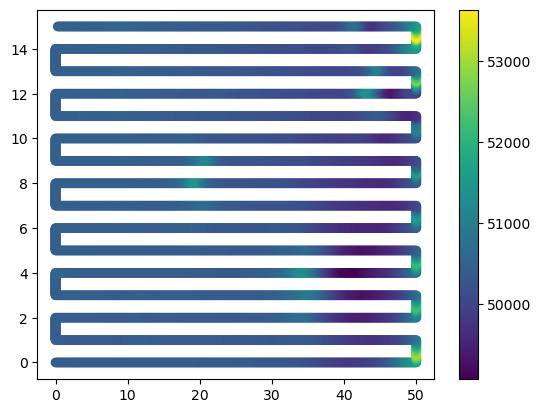

In [146]:
# I'm just doing a quick scatter plot of this data set for viewing purposes, you will still want to:
# 1) Remove the turn around points
# 2) Interpolate the data to make an image.

dat = uxo_mag_data['top sensor (nT)']
plt.scatter(data_locs[:, 0], data_locs[:, 1], c=dat)
plt.colorbar()

At this point, we probably also want to remove the points between lines when the operator was turning around. You can filter out all of those data points on your own.

# Summary
The steps I did to locate the data points:

* Read in the data, split into:
   * Magnetic sensor readings
   * Marked lines
* Associated each marked line with a location in space.
* Linearly interpolated the position between marks in time.

The hardest thing for you will be to associate the marks with locations in space.

**ATTENTION** You still need to apply a drift correction using the base station data